In [ ]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount = True)

Mounted at /content/gdrive


In [ ]:
import sys
sys.path.append('/content/gdrive/MyDrive/ITMO/02_Bright_Field')

In [ ]:
import numpy as np
import os
import datetime
import pandas as pd
import shutil

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
import tensorflow as tf
import tensorflow.keras.backend as K

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

#from Unet_Resnet_Vgg16_others import Unet_Resnet_Vgg16



mol= '_008vggDICEOvrSmpHard_'

# Parameters
PATCH_SIZE = 256
NUM_CHANNELS = 3
NUM_CLASSES = 1
BATCH_SIZE = 16
NUM_EPOC= 45
dt_tm=datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
sys_info=dt_tm
file_Sig=mol+dt_tm



patches_dir = "/content/gdrive/MyDrive/ITMO/01_BRIGHT_FIELD/857x21"

out_path= '/content/gdrive/MyDrive/ITMO/008_OUTPUT/008_Output_Files/'+file_Sig+'/'
tensor_path='/content/gdrive/MyDrive/ITMO/008_OUTPUT/008_TensorBoard/'+file_Sig+'/'
tensor_log_path='/content/gdrive/MyDrive/ITMO/008_OUTPUT/008_TensorBoard/'+file_Sig+'/log/'
keras_path='/content/gdrive/MyDrive/ITMO/008_OUTPUT/008_Keras/'+file_Sig+"/"

keras_file=keras_path+file_Sig+'.keras'

os.makedirs(os.path.join(out_path, 'images'), exist_ok=True)
os.makedirs(keras_path, exist_ok=True)
os.makedirs(tensor_log_path, exist_ok=True)

print(f"File Signature:{file_Sig} indicates file/folder name")

2025-08-02 15:30:47.560010: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754148647.934365      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754148648.041545      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


File Signature:_008vggDICEOvrSmpHard_2025-08-02 15:31:04 indicates file/folder name


In [ ]:

import tensorflow as tf
from tensorflow.keras.layers import (Input, Conv2D, UpSampling2D, BatchNormalization, Activation,
                                     Dropout, Add, Multiply, concatenate)
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
import tensorflow.keras.backend as K

# ------------------- Enable Mixed Precision -------------------
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

# ------------------- Attention Gate -------------------
def attention_gate(x, g, inter_channels):
    theta_x = Conv2D(inter_channels, (1, 1), padding='same')(x)
    phi_g = Conv2D(inter_channels, (1, 1), padding='same')(g)
    add = Add()([theta_x, phi_g])
    act = Activation('relu')(add)
    psi = Conv2D(1, (1, 1), padding='same')(act)
    sigmoid = Activation('sigmoid')(psi)
    out = Multiply()([x, sigmoid])
    return out


# ------------------- Conv Block -------------------
def conv_block(x, filters, dropout_rate=0.1):
    x = Conv2D(filters, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    if dropout_rate:
        x = Dropout(dropout_rate)(x)
    return x

# ------------------- Decoder Block with Attention -------------------
def decoder_block_attention(x, skip, filters):
    g = UpSampling2D((2, 2))(x)
    att = attention_gate(skip, g, filters // 2)
    x = concatenate([g, att])
    x = conv_block(x, filters)
    return x

# ------------------- Build IAUNet (VGG16) -------------------
def build_iaunet_VERSION_REDUCED(input_shape=(256, 256, 3), num_classes=1, trainable_encoder=False):
    inputs = Input(shape=input_shape)

    # ---- Encoder (VGG16) ----
    vgg = VGG16(include_top=False, weights='imagenet', input_tensor=inputs)
    vgg.trainable = False #trainable_encoder

    """
    # Freeze first 10 layers and unfreeze last 10 layers
    total_layers = len(vgg.layers)
    print("******",total_layers)
    for i, layer in enumerate(vgg.layers):
        if i < total_layers - 10:  # First layers (except last 10)
            layer.trainable = False
        else:  # Last 10 layers
            layer.trainable = True
    """
    skips = [
        vgg.get_layer("block1_conv2").output,  # 256x256
        vgg.get_layer("block2_conv2").output,  # 128x128
        vgg.get_layer("block3_conv3").output,  # 64x64
        vgg.get_layer("block4_conv3").output   # 32x32
    ]
    bridge = vgg.get_layer("block5_conv3").output  # 16x16

    # ---- Decoder (reduced filters for memory efficiency) ----
    d1 = decoder_block_attention(bridge, skips[3], 256)  # 16 → 32
    d2 = decoder_block_attention(d1, skips[2], 128)      # 32 → 64
    d3 = decoder_block_attention(d2, skips[1], 64)       # 64 → 128
    d4 = decoder_block_attention(d3, skips[0], 32)       # 128 → 256

    # Output (no over-upsampling)
    output = Conv2D(num_classes, (1, 1), activation='sigmoid', dtype='float32', name='segmentation_output')(d4)

    return Model(inputs, output, name='IAUNet_VGG16_T4Friendly')


# Example usage:
model = build_iaunet_VERSION_REDUCED()
print("Total params:", model.count_params())
print("Trainable params:", sum(tf.keras.backend.count_params(p) for p in model.trainable_weights))

# Debug print for attention and IA layers
print("\nAttention layers params:")
for layer in model.layers:
    if 'attn' in layer.name:
        print(f"{layer.name}: {layer.count_params()} params")

print("\nInstance Activation layers params:")
for layer in model.layers:
    if 'ia' in layer.name:
        print(f"{layer.name}: {layer.count_params()} params")


I0000 00:00:1754148666.534261      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1754148666.534890      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Total params: 18811125
Trainable params: 4094517

Attention layers params:

Instance Activation layers params:


In [ ]:
################---Patch Generator For Training---###################
class PatchDataGenerator(Sequence):
    def __init__(self, patches_dir, indices=None, batch_size=BATCH_SIZE, img_size=PATCH_SIZE, **kwargs):  # ✅ Include **kwargs here
        super().__init__(**kwargs)  # ✅ Now this works
        self.batch_size = batch_size
        self.img_size = img_size
        self.image_files = sorted([os.path.join(patches_dir, 'images', fname) for fname in os.listdir(os.path.join(patches_dir, 'images'))])
        self.mask_files = sorted([os.path.join(patches_dir, 'masks', fname) for fname in os.listdir(os.path.join(patches_dir, 'masks'))])
        if indices is not None:
            self.image_files = [self.image_files[i] for i in indices]
            self.mask_files = [self.mask_files[i] for i in indices]
        self.indices = np.arange(len(self.image_files))

    def __len__(self):
        return len(self.image_files) // self.batch_size

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        X_batch = np.array([np.load(self.image_files[i]) for i in batch_indices])
        Y_batch = np.array([np.load(self.mask_files[i]) for i in batch_indices])
        return X_batch, Y_batch


################## --- Find Hard Patches ---####################
def find_hard_patches(generator, model, threshold=0.3):
    hard_indices = []
    for i in range(len(generator)):
        x_batch, y_batch = generator[i]
        preds = model.predict(x_batch)

        #  Problematic line:
        # error_map = np.abs(preds - y_batch).mean(axis=3)  # <-- only valid if shape is (B, H, W, C)

        #  Fix:
        if preds.ndim == 4:
            error_map = np.abs(preds - y_batch).mean(axis=3)  # Assuming shape: (B, H, W, 1)
        elif preds.ndim == 3:
            error_map = np.abs(preds - y_batch).mean(axis=2)  # (B, H, W)
        else:
            raise ValueError(f"Unexpected prediction shape: {preds.shape}")

        patch_errors = error_map.mean(axis=(1, 2))  # Mean error per image
        for j, err in enumerate(patch_errors):
            if err > threshold:
                hard_indices.append(generator.indices[i * generator.batch_size + j])
    return hard_indices


################## --- Oversample ---#######################
def oversample_generator(train_indices, hard_patches, multiplier=2):
    """
    Oversample hard patches and combine with train_indices.
    """
    # Ensure they're numpy arrays
    train_indices = np.array(train_indices)
    hard_patches = np.array(hard_patches)

    # Oversample hard patches
    repeated_hard = np.tile(hard_patches, multiplier)

    # Combine and shuffle
    combined = np.concatenate([train_indices, repeated_hard])
    np.random.shuffle(combined)

    return combined.tolist()



################## ---Metrics and Loss ---####################

def jaccard_score(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    y_pred = K.round(y_pred)  # Convert probabilities to binary predictions (0 or 1)
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    return (intersection + K.epsilon()) / (union + K.epsilon())  # Add epsilon to avoid division by zero


def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    return true_positives / (predicted_positives + K.epsilon())

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

def dice_loss(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    intersection = K.sum(y_true * y_pred)
    return 1 - (2. * intersection + K.epsilon()) / (K.sum(y_true) + K.sum(y_pred) + K.epsilon())

def dice_bce_loss(y_true, y_pred, bce_weight=0.5, smooth=1e-6):
    # Dice Loss
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice_loss = 1 - (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

    # Weighted BCE (no manual weight needed if using class weights)
    bce_loss = K.binary_crossentropy(y_true, y_pred)

    # Combined Loss
    return bce_weight * bce_loss + (1 - bce_weight) * dice_loss

def weighted_binary_crossentropy(y_true, y_pred):
    weight = 10  # Adjust the weight based on the class imbalance
    bce = K.binary_crossentropy(y_true, y_pred)
    weighted_bce = weight * y_true * bce + (1 - y_true) * bce
    return K.mean(weighted_bce)


def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1. - K.epsilon())
        cross_entropy = -y_true * K.log(y_pred) - (1 - y_true) * K.log(1 - y_pred)
        weight = alpha * K.pow(1 - y_pred, gamma) * y_true + (1 - alpha) * K.pow(y_pred, gamma) * (1 - y_true)
        loss = weight * cross_entropy
        return K.mean(loss)
    return focal_loss_fixed

def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def boundary_loss(y_true, y_pred):
    # Approximate boundary loss using Laplacian filter on y_pred and y_true
    def laplacian_kernel():
        return tf.constant([[0., 1., 0.],
                            [1., -4., 1.],
                            [0., 1., 0.]], shape=(3, 3, 1, 1), dtype=tf.float32)

    kernel = laplacian_kernel()
    y_true_edge = tf.nn.conv2d(y_true, kernel, strides=1, padding='SAME')
    y_pred_edge = tf.nn.conv2d(y_pred, kernel, strides=1, padding='SAME')
    diff = tf.abs(y_true_edge - y_pred_edge)
    return K.mean(diff)

def focal_dice_boundary_loss(y_true, y_pred, alpha=0.25, gamma=2.0, bce_weight=0.3, boundary_weight=0.1):
    fl = focal_loss(gamma=gamma, alpha=alpha)(y_true, y_pred)
    dl = dice_loss(y_true, y_pred)
    bl = boundary_loss(y_true, y_pred)
    return bce_weight * fl + (1 - bce_weight - boundary_weight) * dl + boundary_weight * bl

# Compile Model
#model = Unet_Resnet_Vgg16(backbone="vgg16")
model = build_iaunet_VERSION_REDUCED()
#for layer in model.layers[-20:]:
    #layer.trainable = True


from tensorflow.keras.optimizers.schedules import ExponentialDecay
lr_schedule1 = ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=9000, #10000
    decay_rate=0.9
)

model.compile(
    optimizer=Adam(learning_rate=lr_schedule1),  # Explicitly set learning rate
    loss= dice_bce_loss,  # binary_crossentropy or dice_loss
    metrics=[
        tf.keras.metrics.TruePositives(name="TP"),
        tf.keras.metrics.FalsePositives(name="FP"),
        tf.keras.metrics.TrueNegatives(name="TN"),
        tf.keras.metrics.FalseNegatives(name="FN"),
        'accuracy',
        recall_m,
        precision_m,
        f1_m,
        jaccard_score
    ]
)
#model.summary()

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Data Split
image_files = sorted([os.path.join(patches_dir, 'images', fname) for fname in os.listdir(os.path.join(patches_dir, 'images'))])
mask_files = sorted([os.path.join(patches_dir, 'masks', fname) for fname in os.listdir(os.path.join(patches_dir, 'masks'))])
train_indices, val_indices = train_test_split(np.arange(len(image_files)), test_size=0.2, random_state=42)

train_gen = PatchDataGenerator(patches_dir, indices=train_indices, batch_size=BATCH_SIZE)
val_gen = PatchDataGenerator(patches_dir, indices=val_indices, batch_size=BATCH_SIZE)


# Callbacks
log_dir = "logs/fit/kan_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True, write_images=True, update_freq='epoch' )
#checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(keras_file, save_best_only=True)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=keras_path+file_Sig+"_1st_{epoch:02d}.keras",  # dynamic naming
    save_freq='epoch',
    save_weights_only=False,  # Save the full model (not just weights)
    save_best_only=False,     # Save all epochs (not just the best one)
    verbose=1
)




csv_logger = tf.keras.callbacks.CSVLogger("training_log.csv", append=True)
# Train with more epochs
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=NUM_EPOC,
    callbacks=[csv_logger, tensorboard_callback, checkpoint_callback, early_stopping],
    verbose=1,
    #workers=4,
    #use_multiprocessing=True,
    #max_queue_size=10
)
print("First training phase metrics/epochs:")
print(history.history)


Epoch 1/50


I0000 00:00:1754148688.085796      95 service.cc:148] XLA service 0x7d9458003680 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754148688.087656      95 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1754148688.087677      95 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1754148690.071877      95 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-08-02 15:31:52.855189: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f16[16,256,256,128]{3,2,1,0}, u8[0]{0}) custom-call(f16[16,256,256,32]{3,2,1,0}, f16[32,3,3,128]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardInput", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_q

899/899 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step - FN: 27795008.0000 - FP: 40611512.0000 - TN: 330725792.0000 - TP: 72726704.0000 - accuracy: 0.8427 - f1_m: 0.6482 - jaccard_score: 0.4889 - loss: 0.4002 - precision_m: 0.6101 - recall_m: 0.7059
Epoch 1: saving model to /kaggle/working/008_OUTPUT/008_Keras/_008vggDICEOvrSmpHard_2025-08-02 15:31:04/_008vggDICEOvrSmpHard_2025-08-02 15:31:04_1st_01.keras
899/899 ━━━━━━━━━━━━━━━━━━━━ 857s 655ms/step - FN: 27824094.0000 - FP: 40647852.0000 - TN: 331099456.0000 - TP: 72810752.0000 - accuracy: 0.8427 - f1_m: 0.6483 - jaccard_score: 0.4890 - loss: 0.4001 - precision_m: 0.6101 - recall_m: 0.7060 - val_FN: 11299025.0000 - val_FP: 14239978.0000 - val_TN: 172802656.0000 - val_TP: 37587912.0000 - val_accuracy: 0.8918 - val_f1_m: 0.7427 - val_jaccard_score: 0.5934 - val_loss: 0.2828 - val_precision_m: 0.7241 - val_recall_m: 0.7660
Epoch 2/50
899/899 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - FN: 24388112.0000 - FP: 27062858.0000 - TN: 342749184.0000 - TP: 7765911

In [ ]:
# --- Mine Hard Patches and Train Again ---

hard_patches = find_hard_patches(train_gen, model, threshold=0.3)
print(f"Oversampling {len(hard_patches)} hard patches...")

# Try oversampling with hard patches
if len(hard_patches) > 0:
    new_train_indices = oversample_generator(train_indices, hard_patches, multiplier=2)
else:
    print("[WARNING] No hard patches found. Using original train_indices.")
    new_train_indices = train_indices

# Final fallback: make sure train indices is not empty
if new_train_indices is None or len(new_train_indices) == 0:
    print("FATAL WARNING: new_train_indices is empty. Falling back to original train_indices.")
    new_train_indices = train_indices


#new_train_indices = oversample_generator(train_indices, hard_patches, multiplier=2)

# Final fallback: make sure train indices is not empty
if new_train_indices is None or len(new_train_indices) == 0:
    print("FATAL WARNING: new_train_indices is empty. Falling back to original train_indices.")
    new_train_indices = train_indices

train_gen_updated = PatchDataGenerator(patches_dir, indices=new_train_indices, batch_size=BATCH_SIZE)



# Log generator status
print(f"[INFO] Final train batches: {len(train_gen)} | Validation batches: {len(val_gen)}")

# Final hard stop to avoid crash
if len(train_gen) == 0:
    raise ValueError("❌ train_gen is empty. Fix your indices or data.")

csv_logger = tf.keras.callbacks.CSVLogger("training_log.csv", append=True)

# --- Second Phase Training ---
#history2 = model.fit(train_gen_updated, validation_data=val_gen, epochs=25, callbacks=callbacks, verbose=1)

history2 = model.fit(
    train_gen_updated,
    validation_data=val_gen,
    epochs=NUM_EPOC,
    callbacks=[csv_logger, tensorboard_callback, checkpoint_callback, early_stopping],
    verbose=1,
    #workers=4,
    #use_multiprocessing=True,
    #max_queue_size=10
)
print("\nSecond training phase (after hard patch mining) metrics/epochs:")
print(history2.history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [ ]:
import pandas as pd
df = pd.read_csv("training_log.csv")
print(df.head())

   epoch          FN          FP           TN           TP  accuracy  \
0      0  53972704.0  73315888.0  667003968.0  148376688.0  0.864970   
1      1  48263060.0  52904092.0  687416512.0  154086320.0  0.892680   
2      2  43934032.0  47134272.0  693186176.0  158415376.0  0.903393   
3      3  40195600.0  42856248.0  697464704.0  162153888.0  0.911897   
4      4  37471072.0  39694436.0  700625536.0  164878336.0  0.918141   

       f1_m  jaccard_score      loss  precision_m  ...      val_FN  \
0  0.697811       0.540599  0.348133     0.668636  ...  11299025.0   
1  0.750702       0.603374  0.281728     0.740962  ...  11107779.0   
2  0.774424       0.634178  0.254720     0.767296  ...  11802935.0   
3  0.793640       0.660081  0.233751     0.787624  ...   9990256.0   
4  0.808132       0.680081  0.218282     0.803150  ...   9399171.0   

       val_FP       val_TN      val_TP  val_accuracy  val_f1_m  \
0  14239978.0  172802656.0  37587912.0      0.891751  0.742716   
1  11901031.0 

In [ ]:
import os
# It saves locally in Colab as 'training_log.csv'
local_csv_path = 'training_log.csv'
drive_csv_path = os.path.join(tensor_log_path, f'training_log_{file_Sig}.csv')

if os.path.exists(local_csv_path):
    shutil.copy(local_csv_path, drive_csv_path)
    print(f"Copied existing CSVLogger file to: {drive_csv_path}")

Copied existing CSVLogger file to: /kaggle/working/008_OUTPUT/008_TensorBoard/_008vggDICEOvrSmpHard_2025-08-02 15:31:04/log/training_log__008vggDICEOvrSmpHard_2025-08-02 15:31:04.csv


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


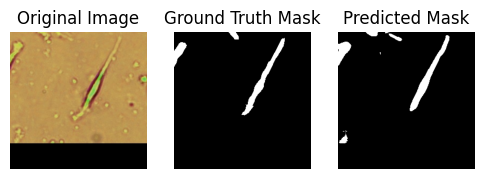

Saved: /kaggle/working/008_OUTPUT/008_Output_Files/_008vggDICEOvrSmpHard_2025-08-02 15:31:04/prediction__008vggDICEOvrSmpHard_2025-08-02 15:31:04_1.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


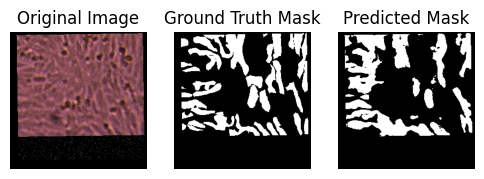

Saved: /kaggle/working/008_OUTPUT/008_Output_Files/_008vggDICEOvrSmpHard_2025-08-02 15:31:04/prediction__008vggDICEOvrSmpHard_2025-08-02 15:31:04_2.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


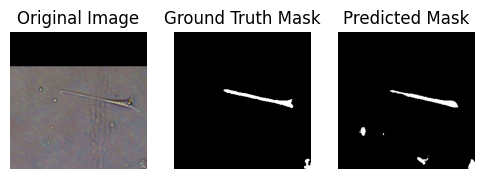

Saved: /kaggle/working/008_OUTPUT/008_Output_Files/_008vggDICEOvrSmpHard_2025-08-02 15:31:04/prediction__008vggDICEOvrSmpHard_2025-08-02 15:31:04_3.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


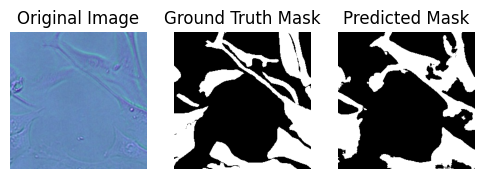

Saved: /kaggle/working/008_OUTPUT/008_Output_Files/_008vggDICEOvrSmpHard_2025-08-02 15:31:04/prediction__008vggDICEOvrSmpHard_2025-08-02 15:31:04_4.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


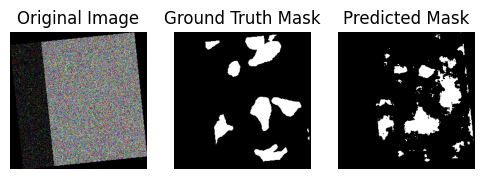

Saved: /kaggle/working/008_OUTPUT/008_Output_Files/_008vggDICEOvrSmpHard_2025-08-02 15:31:04/prediction__008vggDICEOvrSmpHard_2025-08-02 15:31:04_5.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


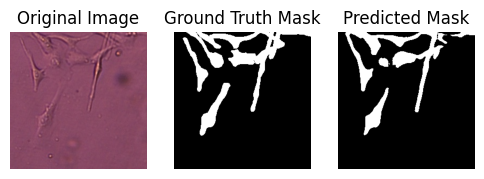

Saved: /kaggle/working/008_OUTPUT/008_Output_Files/_008vggDICEOvrSmpHard_2025-08-02 15:31:04/prediction__008vggDICEOvrSmpHard_2025-08-02 15:31:04_6.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


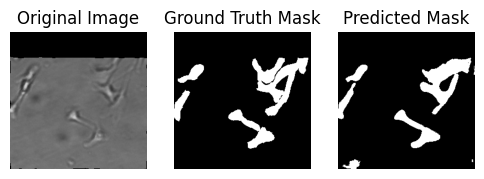

Saved: /kaggle/working/008_OUTPUT/008_Output_Files/_008vggDICEOvrSmpHard_2025-08-02 15:31:04/prediction__008vggDICEOvrSmpHard_2025-08-02 15:31:04_7.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


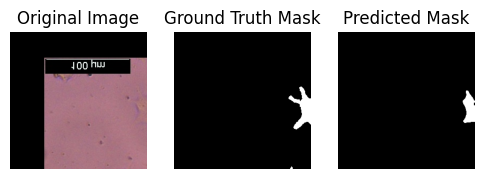

Saved: /kaggle/working/008_OUTPUT/008_Output_Files/_008vggDICEOvrSmpHard_2025-08-02 15:31:04/prediction__008vggDICEOvrSmpHard_2025-08-02 15:31:04_8.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


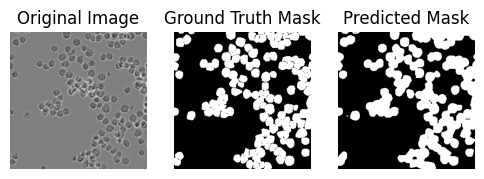

Saved: /kaggle/working/008_OUTPUT/008_Output_Files/_008vggDICEOvrSmpHard_2025-08-02 15:31:04/prediction__008vggDICEOvrSmpHard_2025-08-02 15:31:04_9.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


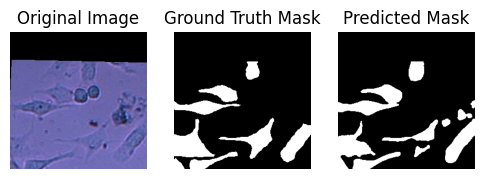

Saved: /kaggle/working/008_OUTPUT/008_Output_Files/_008vggDICEOvrSmpHard_2025-08-02 15:31:04/prediction__008vggDICEOvrSmpHard_2025-08-02 15:31:04_10.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


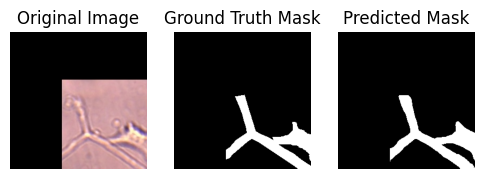

Saved: /kaggle/working/008_OUTPUT/008_Output_Files/_008vggDICEOvrSmpHard_2025-08-02 15:31:04/prediction__008vggDICEOvrSmpHard_2025-08-02 15:31:04_11.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


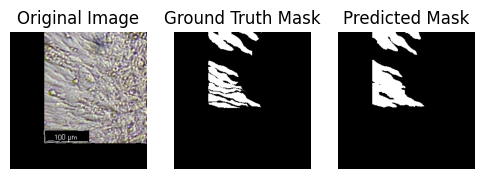

Saved: /kaggle/working/008_OUTPUT/008_Output_Files/_008vggDICEOvrSmpHard_2025-08-02 15:31:04/prediction__008vggDICEOvrSmpHard_2025-08-02 15:31:04_12.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


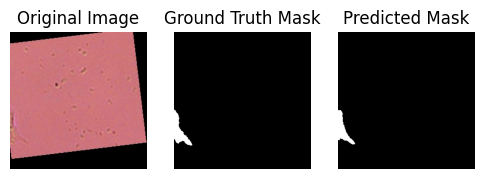

Saved: /kaggle/working/008_OUTPUT/008_Output_Files/_008vggDICEOvrSmpHard_2025-08-02 15:31:04/prediction__008vggDICEOvrSmpHard_2025-08-02 15:31:04_13.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


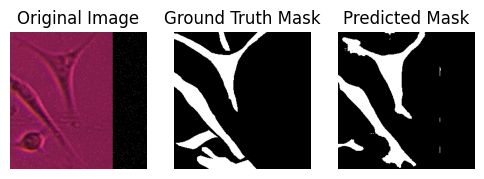

Saved: /kaggle/working/008_OUTPUT/008_Output_Files/_008vggDICEOvrSmpHard_2025-08-02 15:31:04/prediction__008vggDICEOvrSmpHard_2025-08-02 15:31:04_14.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


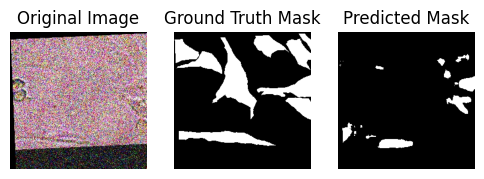

Saved: /kaggle/working/008_OUTPUT/008_Output_Files/_008vggDICEOvrSmpHard_2025-08-02 15:31:04/prediction__008vggDICEOvrSmpHard_2025-08-02 15:31:04_15.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


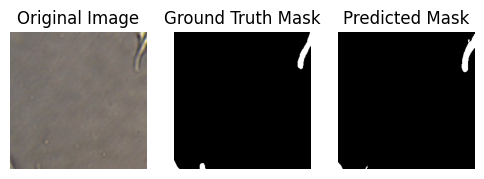

Saved: /kaggle/working/008_OUTPUT/008_Output_Files/_008vggDICEOvrSmpHard_2025-08-02 15:31:04/prediction__008vggDICEOvrSmpHard_2025-08-02 15:31:04_16.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


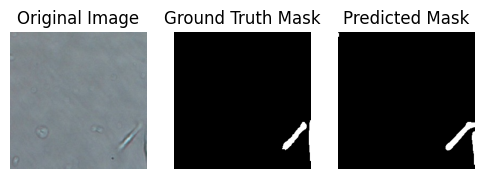

Saved: /kaggle/working/008_OUTPUT/008_Output_Files/_008vggDICEOvrSmpHard_2025-08-02 15:31:04/prediction__008vggDICEOvrSmpHard_2025-08-02 15:31:04_17.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


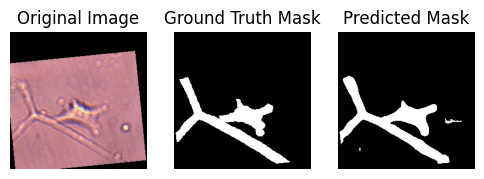

Saved: /kaggle/working/008_OUTPUT/008_Output_Files/_008vggDICEOvrSmpHard_2025-08-02 15:31:04/prediction__008vggDICEOvrSmpHard_2025-08-02 15:31:04_18.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


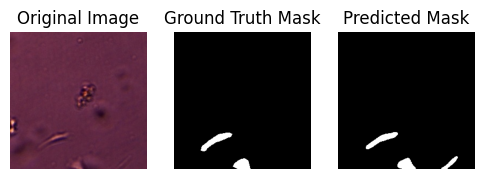

Saved: /kaggle/working/008_OUTPUT/008_Output_Files/_008vggDICEOvrSmpHard_2025-08-02 15:31:04/prediction__008vggDICEOvrSmpHard_2025-08-02 15:31:04_19.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


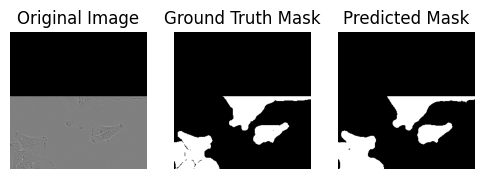

Saved: /kaggle/working/008_OUTPUT/008_Output_Files/_008vggDICEOvrSmpHard_2025-08-02 15:31:04/prediction__008vggDICEOvrSmpHard_2025-08-02 15:31:04_20.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


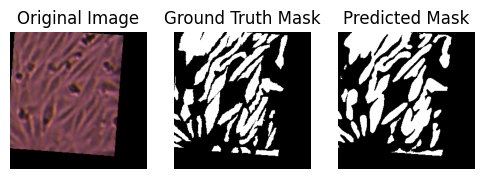

Saved: /kaggle/working/008_OUTPUT/008_Output_Files/_008vggDICEOvrSmpHard_2025-08-02 15:31:04/prediction__008vggDICEOvrSmpHard_2025-08-02 15:31:04_21.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


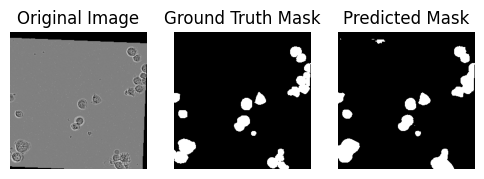

Saved: /kaggle/working/008_OUTPUT/008_Output_Files/_008vggDICEOvrSmpHard_2025-08-02 15:31:04/prediction__008vggDICEOvrSmpHard_2025-08-02 15:31:04_22.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


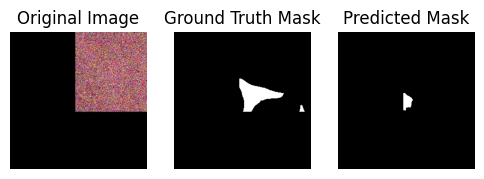

Saved: /kaggle/working/008_OUTPUT/008_Output_Files/_008vggDICEOvrSmpHard_2025-08-02 15:31:04/prediction__008vggDICEOvrSmpHard_2025-08-02 15:31:04_23.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


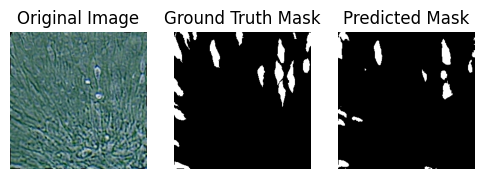

Saved: /kaggle/working/008_OUTPUT/008_Output_Files/_008vggDICEOvrSmpHard_2025-08-02 15:31:04/prediction__008vggDICEOvrSmpHard_2025-08-02 15:31:04_24.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


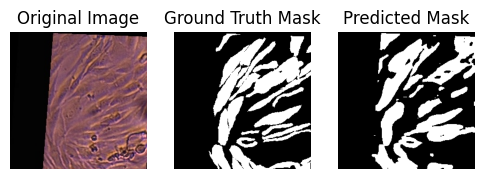

Saved: /kaggle/working/008_OUTPUT/008_Output_Files/_008vggDICEOvrSmpHard_2025-08-02 15:31:04/prediction__008vggDICEOvrSmpHard_2025-08-02 15:31:04_25.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


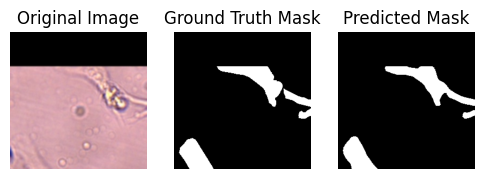

Saved: /kaggle/working/008_OUTPUT/008_Output_Files/_008vggDICEOvrSmpHard_2025-08-02 15:31:04/prediction__008vggDICEOvrSmpHard_2025-08-02 15:31:04_26.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


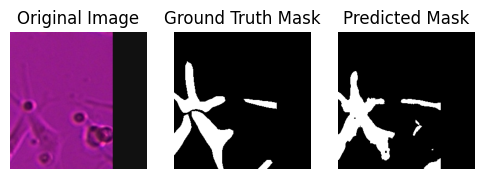

Saved: /kaggle/working/008_OUTPUT/008_Output_Files/_008vggDICEOvrSmpHard_2025-08-02 15:31:04/prediction__008vggDICEOvrSmpHard_2025-08-02 15:31:04_27.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


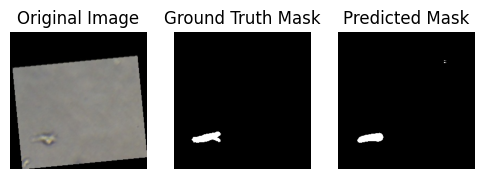

Saved: /kaggle/working/008_OUTPUT/008_Output_Files/_008vggDICEOvrSmpHard_2025-08-02 15:31:04/prediction__008vggDICEOvrSmpHard_2025-08-02 15:31:04_28.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


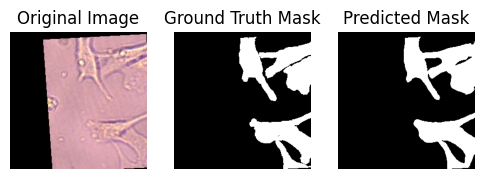

Saved: /kaggle/working/008_OUTPUT/008_Output_Files/_008vggDICEOvrSmpHard_2025-08-02 15:31:04/prediction__008vggDICEOvrSmpHard_2025-08-02 15:31:04_29.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


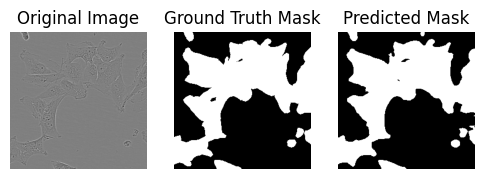

Saved: /kaggle/working/008_OUTPUT/008_Output_Files/_008vggDICEOvrSmpHard_2025-08-02 15:31:04/prediction__008vggDICEOvrSmpHard_2025-08-02 15:31:04_30.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


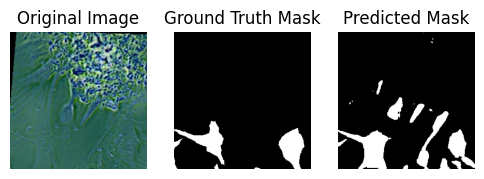

Saved: /kaggle/working/008_OUTPUT/008_Output_Files/_008vggDICEOvrSmpHard_2025-08-02 15:31:04/prediction__008vggDICEOvrSmpHard_2025-08-02 15:31:04_31.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


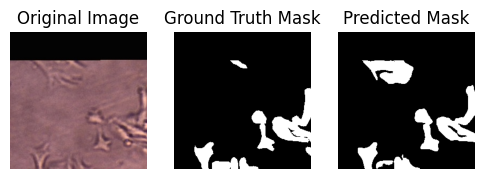

Saved: /kaggle/working/008_OUTPUT/008_Output_Files/_008vggDICEOvrSmpHard_2025-08-02 15:31:04/prediction__008vggDICEOvrSmpHard_2025-08-02 15:31:04_32.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


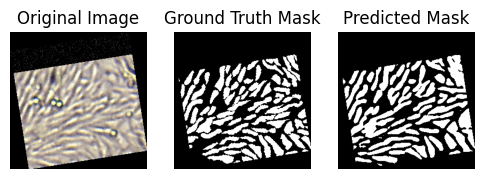

Saved: /kaggle/working/008_OUTPUT/008_Output_Files/_008vggDICEOvrSmpHard_2025-08-02 15:31:04/prediction__008vggDICEOvrSmpHard_2025-08-02 15:31:04_33.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


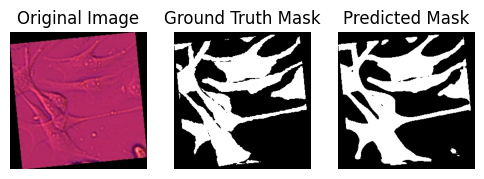

Saved: /kaggle/working/008_OUTPUT/008_Output_Files/_008vggDICEOvrSmpHard_2025-08-02 15:31:04/prediction__008vggDICEOvrSmpHard_2025-08-02 15:31:04_34.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


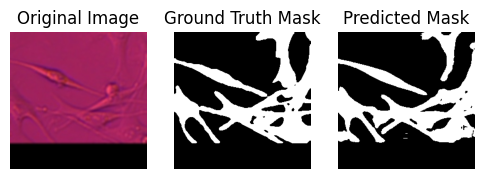

Saved: /kaggle/working/008_OUTPUT/008_Output_Files/_008vggDICEOvrSmpHard_2025-08-02 15:31:04/prediction__008vggDICEOvrSmpHard_2025-08-02 15:31:04_35.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


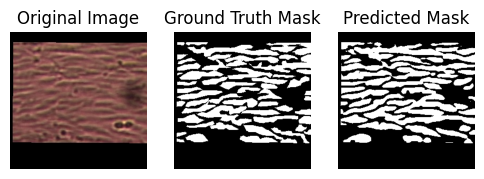

Saved: /kaggle/working/008_OUTPUT/008_Output_Files/_008vggDICEOvrSmpHard_2025-08-02 15:31:04/prediction__008vggDICEOvrSmpHard_2025-08-02 15:31:04_36.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


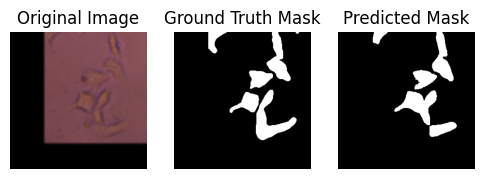

Saved: /kaggle/working/008_OUTPUT/008_Output_Files/_008vggDICEOvrSmpHard_2025-08-02 15:31:04/prediction__008vggDICEOvrSmpHard_2025-08-02 15:31:04_37.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


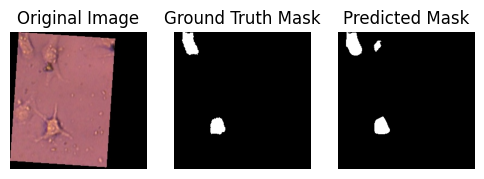

Saved: /kaggle/working/008_OUTPUT/008_Output_Files/_008vggDICEOvrSmpHard_2025-08-02 15:31:04/prediction__008vggDICEOvrSmpHard_2025-08-02 15:31:04_38.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


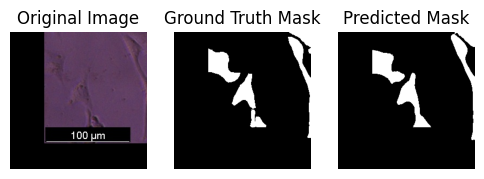

Saved: /kaggle/working/008_OUTPUT/008_Output_Files/_008vggDICEOvrSmpHard_2025-08-02 15:31:04/prediction__008vggDICEOvrSmpHard_2025-08-02 15:31:04_39.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


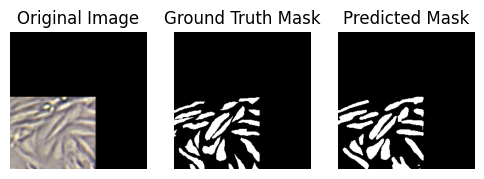

Saved: /kaggle/working/008_OUTPUT/008_Output_Files/_008vggDICEOvrSmpHard_2025-08-02 15:31:04/prediction__008vggDICEOvrSmpHard_2025-08-02 15:31:04_40.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


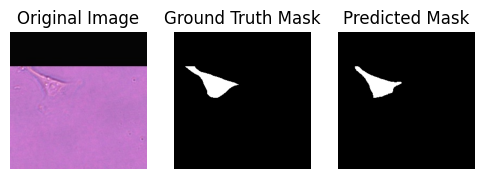

Saved: /kaggle/working/008_OUTPUT/008_Output_Files/_008vggDICEOvrSmpHard_2025-08-02 15:31:04/prediction__008vggDICEOvrSmpHard_2025-08-02 15:31:04_41.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


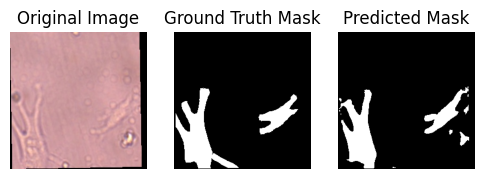

Saved: /kaggle/working/008_OUTPUT/008_Output_Files/_008vggDICEOvrSmpHard_2025-08-02 15:31:04/prediction__008vggDICEOvrSmpHard_2025-08-02 15:31:04_42.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


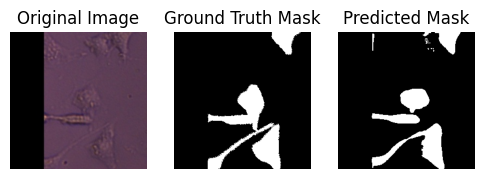

Saved: /kaggle/working/008_OUTPUT/008_Output_Files/_008vggDICEOvrSmpHard_2025-08-02 15:31:04/prediction__008vggDICEOvrSmpHard_2025-08-02 15:31:04_43.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


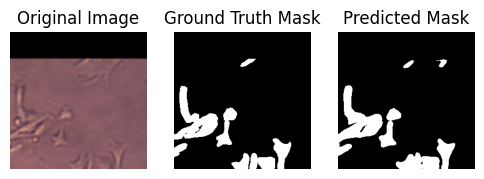

Saved: /kaggle/working/008_OUTPUT/008_Output_Files/_008vggDICEOvrSmpHard_2025-08-02 15:31:04/prediction__008vggDICEOvrSmpHard_2025-08-02 15:31:04_44.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


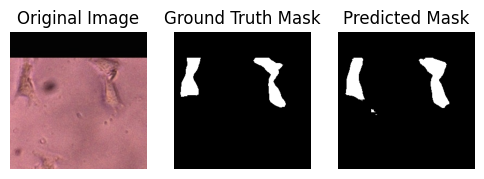

Saved: /kaggle/working/008_OUTPUT/008_Output_Files/_008vggDICEOvrSmpHard_2025-08-02 15:31:04/prediction__008vggDICEOvrSmpHard_2025-08-02 15:31:04_45.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


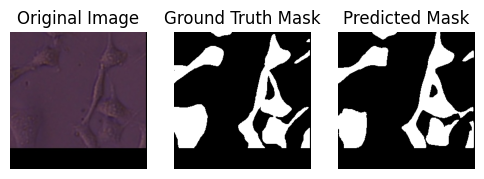

Saved: /kaggle/working/008_OUTPUT/008_Output_Files/_008vggDICEOvrSmpHard_2025-08-02 15:31:04/prediction__008vggDICEOvrSmpHard_2025-08-02 15:31:04_46.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


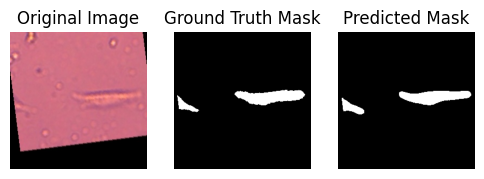

Saved: /kaggle/working/008_OUTPUT/008_Output_Files/_008vggDICEOvrSmpHard_2025-08-02 15:31:04/prediction__008vggDICEOvrSmpHard_2025-08-02 15:31:04_47.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


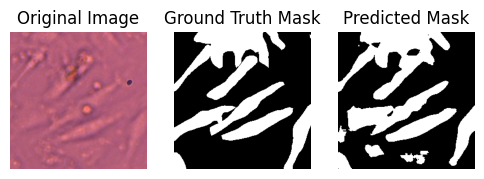

Saved: /kaggle/working/008_OUTPUT/008_Output_Files/_008vggDICEOvrSmpHard_2025-08-02 15:31:04/prediction__008vggDICEOvrSmpHard_2025-08-02 15:31:04_48.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


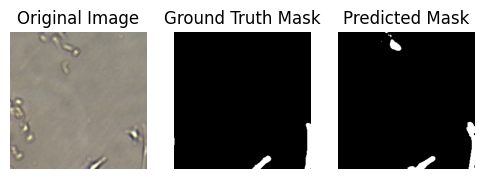

Saved: /kaggle/working/008_OUTPUT/008_Output_Files/_008vggDICEOvrSmpHard_2025-08-02 15:31:04/prediction__008vggDICEOvrSmpHard_2025-08-02 15:31:04_49.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


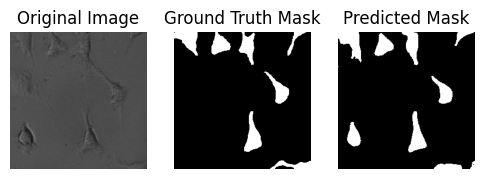

Saved: /kaggle/working/008_OUTPUT/008_Output_Files/_008vggDICEOvrSmpHard_2025-08-02 15:31:04/prediction__008vggDICEOvrSmpHard_2025-08-02 15:31:04_50.png


In [ ]:
def visualize_predictions(generator, model, num_images=25, save_dir=out_path):
    os.makedirs(save_dir, exist_ok=True)  # Create directory if it doesn't exist

    for i in range(num_images):
        X_batch, Y_batch = generator[i]
        preds = (model.predict(X_batch) > 0.5).astype("int32")

        fig, axs = plt.subplots(1, 3, figsize=(6, 2))

        axs[0].imshow(X_batch[0])
        axs[0].set_title("Original Image")

        axs[1].imshow(Y_batch[0].squeeze(), cmap='gray')
        axs[1].set_title("Ground Truth Mask")

        axs[2].imshow(preds[0].squeeze(), cmap='gray')
        axs[2].set_title("Predicted Mask")

        # Remove axes for clarity
        for ax in axs:
            ax.axis('off')

        # Save figure
        fig_path = os.path.join(save_dir, f"prediction_{file_Sig}_{i+1}.png")
        plt.savefig(fig_path, bbox_inches='tight')
        #plt.close(fig)

        # Display inline
        plt.show(fig)

        # Optional: close to free memory
        plt.close(fig)
        print(f"Saved: {fig_path}")

# Run Visualization
visualize_predictions(val_gen, model, num_images=50)

In [ ]:
import shutil
import os

# Define paths
local_log_dir = "logs"  # Your existing log directory
drive_log_dir =  tensor_path  # Target in Drive

# Create destination directory if it doesn't exist
os.makedirs(drive_log_dir, exist_ok=True)

# Copy logs to Drive (preserves existing)
shutil.copytree(local_log_dir,
                os.path.join(drive_log_dir, os.path.basename(local_log_dir)),
                dirs_exist_ok=True)  # Important for appending!

print(f"Logs copied to: {drive_log_dir}")

Logs copied to: /kaggle/working/008_OUTPUT/008_TensorBoard/_008vggDICEOvrSmpHard_2025-08-02 15:31:04/


In [ ]:
import os

log_path = tensor_path+"/logs"
for root, dirs, files in os.walk(log_path):
    for f in files:
        if 'tfevents' in f:
            print("Found TensorBoard file:", os.path.join(root, f))

Found TensorBoard file: /kaggle/working/008_OUTPUT/008_TensorBoard/_008vggDICEOvrSmpHard_2025-08-02 15:31:04//logs/fit/kan_20250802-153110/validation/events.out.tfevents.1754149376.2765566a4cfe.36.1.v2
Found TensorBoard file: /kaggle/working/008_OUTPUT/008_TensorBoard/_008vggDICEOvrSmpHard_2025-08-02 15:31:04//logs/fit/kan_20250802-153110/validation/events.out.tfevents.1754155784.2765566a4cfe.36.3.v2
Found TensorBoard file: /kaggle/working/008_OUTPUT/008_TensorBoard/_008vggDICEOvrSmpHard_2025-08-02 15:31:04//logs/fit/kan_20250802-153110/train/events.out.tfevents.1754155632.2765566a4cfe.36.2.v2
Found TensorBoard file: /kaggle/working/008_OUTPUT/008_TensorBoard/_008vggDICEOvrSmpHard_2025-08-02 15:31:04//logs/fit/kan_20250802-153110/train/events.out.tfevents.1754148671.2765566a4cfe.36.0.v2


In [ ]:
!pip install GPUtil

  Preparing metadata (setup.py) ... done
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7392 sha256=fc7ee10b2edebb1199d14234fc1e05e207c0ce0fd2fce12091d03e68100b21be
  Stored in directory: /root/.cache/pip/wheels/2b/4d/8f/55fb4f7b9b591891e8d3f72977c4ec6c7763b39c19f0861595
Successfully built GPUtil


In [ ]:
import platform
import psutil
import cpuinfo
import GPUtil
import subprocess
import pkg_resources
import socket
from datetime import datetime

def get_hardware_info():
    print("\n" + "="*40 + " Hardware Information " + "="*40)

    # System Information
    print("\n" + "-"*20 + " System Information " + "-"*20)
    print(f"System: {platform.system()}")
    print(f"Node Name: {platform.node()}")
    print(f"Release: {platform.release()}")
    print(f"Version: {platform.version()}")
    print(f"Machine: {platform.machine()}")
    print(f"Processor: {platform.processor()}")

    # CPU Information
    print("\n" + "-"*20 + " CPU Information " + "-"*20)
    cpu_info = cpuinfo.get_cpu_info()
    print(f"Processor: {cpu_info['brand_raw']}")
    print(f"Architecture: {cpu_info['arch']}")
    print(f"Bits: {cpu_info['bits']}")
    print(f"Count: {psutil.cpu_count(logical=False)} physical, {psutil.cpu_count(logical=True)} logical")
    print(f"Max Frequency: {psutil.cpu_freq().max:.2f} MHz")
    print(f"Current Frequency: {psutil.cpu_freq().current:.2f} MHz")

    # Memory Information
    print("\n" + "-"*20 + " Memory Information " + "-"*20)
    svmem = psutil.virtual_memory()
    print(f"Total RAM: {svmem.total / (1024**3):.2f} GB")
    print(f"Available RAM: {svmem.available / (1024**3):.2f} GB")
    print(f"Used RAM: {svmem.used / (1024**3):.2f} GB")
    print(f"RAM Usage: {svmem.percent}%")

    # Disk Information
    print("\n" + "-"*20 + " Disk Information " + "-"*20)
    partitions = psutil.disk_partitions()
    for partition in partitions:
        try:
            usage = psutil.disk_usage(partition.mountpoint)
            print(f"Device: {partition.device}")
            print(f"  Mountpoint: {partition.mountpoint}")
            print(f"  File System: {partition.fstype}")
            print(f"  Total Size: {usage.total / (1024**3):.2f} GB")
            print(f"  Used: {usage.used / (1024**3):.2f} GB")
            print(f"  Free: {usage.free / (1024**3):.2f} GB")
            print(f"  Usage: {usage.percent}%")
        except PermissionError:
            continue

    # GPU Information
    print("\n" + "-"*20 + " GPU Information " + "-"*20)
    try:
        gpus = GPUtil.getGPUs()
        for i, gpu in enumerate(gpus):
            print(f"GPU {i}: {gpu.name}")
            print(f"  Driver: {gpu.driver}")
            print(f"  Memory Total: {gpu.memoryTotal} MB")
            print(f"  Memory Free: {gpu.memoryFree} MB")
            print(f"  Memory Used: {gpu.memoryUsed} MB")
            print(f"  GPU Utilization: {gpu.load*100}%")
            print(f"  Temperature: {gpu.temperature} °C")
    except Exception as e:
        print(f"Could not retrieve GPU information: {e}")

def get_installed_libraries():
    print("\n" + "="*40 + " Library Information " + "="*40)

    # Get all installed packages
    installed_packages = pkg_resources.working_set

    # Common ML/DL libraries to check
    important_libraries = [
        'tensorflow', 'tensorflow-gpu', 'torch', 'torchvision', 'torchaudio',
        'numpy', 'scipy', 'pandas', 'matplotlib', 'scikit-learn',
        'keras', 'opencv-python', 'pillow', 'jupyter', 'seaborn',
        'xgboost', 'lightgbm', 'catboost', 'transformers', 'datasets',
        'flask', 'django', 'fastapi', 'requests', 'beautifulsoup4',
        'pytorch', 'cuda', 'cudnn'
    ]

    print("\n" + "-"*20 + " Key Libraries " + "-"*20)
    for lib in important_libraries:
        try:
            version = pkg_resources.get_distribution(lib).version
            print(f"{lib}: {version}")
        except:
            pass

    # Get all installed packages if needed
    # print("\n" + "-"*20 + " All Installed Packages " + "-"*20)
    # for package in sorted(installed_packages, key=lambda x: x.key):
    #     print(f"{package.key}: {package.version}")

def save_to_file(info, filename="system_info.txt"):
    with open(filename, "w") as f:
        f.write(info)
    print(f"\nInformation saved to {filename}")

def main():
    import io
    import sys

    # Redirect stdout to capture all output
    old_stdout = sys.stdout
    sys.stdout = buffer = io.StringIO()

    # Get current date and time
    print(f"System and Library Information - {sys_info}")
    print("="*100)

    # Get hardware info
    get_hardware_info()

    # Get library info
    get_installed_libraries()

    # Restore stdout
    sys.stdout = old_stdout

    # Get the captured output
    info = buffer.getvalue()

    # Print to console
    print(info)

    # Save to file
    save_to_file(info)

if __name__ == "__main__":
    main()

System and Library Information - 2025-08-02 15:31:04

======================================== Hardware Information ========================================

-------------------- System Information --------------------
System: Linux
Node Name: 2765566a4cfe
Release: 6.6.56+
Version: #1 SMP PREEMPT_DYNAMIC Sun Nov 10 10:07:59 UTC 2024
Machine: x86_64
Processor: x86_64

-------------------- CPU Information --------------------
Processor: Intel(R) Xeon(R) CPU @ 2.00GHz
Architecture: X86_64
Bits: 64
Count: 2 physical, 4 logical
Max Frequency: 0.00 MHz
Current Frequency: 2000.17 MHz

-------------------- Memory Information --------------------
Total RAM: 31.35 GB
Available RAM: 26.32 GB
Used RAM: 4.49 GB
RAM Usage: 16.0%

-------------------- Disk Information --------------------
Device: /dev/sdb1
  Mountpoint: /opt/bin
  File System: ext4
  Total Size: 121.82 GB
  Used: 10.47 GB
  Free: 111.33 GB
  Usage: 8.6%
Device: /dev/loop1
  Mountpoint: /kaggle/lib
  File System: ext4
  Total Size: 19

In [ ]:
import shutil

src = "/kaggle/working/system_info.txt"
dst = "/kaggle/working/008_OUTPUT/system_info.txt"

shutil.move(src, dst)

'/kaggle/working/008_OUTPUT/system_info.txt'

In [ ]:
import os

root_dir = '/kaggle/working'

for root, dirs, files in os.walk(root_dir):
    level = root.replace(root_dir, '').count(os.sep)
    indent = ' ' * 4 * level
    print(f"{indent}{os.path.basename(root)}/")
    sub_indent = ' ' * 4 * (level + 1)
    for f in files:
        print(f"{sub_indent}{f}")

working/
    training_log.csv
    logs/
        fit/
            kan_20250802-153110/
                validation/
                    events.out.tfevents.1754149376.2765566a4cfe.36.1.v2
                    events.out.tfevents.1754155784.2765566a4cfe.36.3.v2
                train/
                    events.out.tfevents.1754155632.2765566a4cfe.36.2.v2
                    events.out.tfevents.1754148671.2765566a4cfe.36.0.v2
    .virtual_documents/
    008_OUTPUT/
        system_info.txt
        008_Output_Files/
            _008vggDICEOvrSmpHard_2025-08-02 15:31:04/
                prediction__008vggDICEOvrSmpHard_2025-08-02 15:31:04_14.png
                prediction__008vggDICEOvrSmpHard_2025-08-02 15:31:04_37.png
                prediction__008vggDICEOvrSmpHard_2025-08-02 15:31:04_39.png
                prediction__008vggDICEOvrSmpHard_2025-08-02 15:31:04_49.png
                prediction__008vggDICEOvrSmpHard_2025-08-02 15:31:04_1.png
                prediction__008vggDICEOvrSmpHard_20

In [ ]:
import shutil

folder_to_zip = "/kaggle/working/008_OUTPUT"
output_zip_path = "/kaggle/working/008vggDICEOvrSmpHard"

shutil.make_archive(output_zip_path, 'zip', folder_to_zip)

'/kaggle/working/008vggDICEOvrSmpHard.zip'